In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

In [2]:
hubble = 0.697
BoxSize = 64.0

In [3]:
def load_rockstar_data(rockstar_name, boxsize=64.0):
    dtype=[
        ('ID' ,'i8'),('DescID' ,'i8'),('Mvir','f8'),('Vmax','f8'),('Vrms','f8'),('Rvir','f8'),('Rs','f8'),( 'Np','i8'),
        ( 'X','f8'),( 'Y','f8'),( 'Z','f8'),( 'VX','f8'),( 'VY','f8'),( 'VZ','f8'),
        ( 'JX','f8'),( 'JY','f8'),( 'JZ','f8'),( 'Spin','f8'),( 'rs_klypin' ,'f8'),('Mvir_all' ,'f8'),('M200b','f8'),
        ( 'M200c','f8'),( 'M500c','f8'),( 'M2500c' ,'f8'),('Xoff','f8'),( 'Voff','f8'),( 'spin_bullock','f8'),
        ( 'b_to_a','f8'),( 'c_to_a','f8'),( 'A[x]' ,'f8'),('A[y]','f8'),('A[z]','f8'),
        ( 'b_to_a(500c)' ,'f8'),('c_to_a(500c)' ,'f8'),('A[x](500c)','f8'),( 'A[y](500c)' ,'f8'),
        ('A[z](500c)' ,'f8'),('T_U','f8'),( 'M_pe_Behroozi','f8'),( 'M_pe_Diemer','f8'),('Halfmass_Radius','f8'), 
        ('PID', 'i8')]
    snap_data = np.loadtxt(rockstar_name, dtype=dtype)    
   
    return snap_data

In [4]:
gr_full_data = load_rockstar_data('../data/halos/GR/out_0.list')
fr_full_data = load_rockstar_data('../data/halos/FR6/out_0.list')

In [5]:
ii = (gr_full_data['Mvir']/hubble > 1E11) & (gr_full_data['PID']==-1)
gr_data = gr_full_data[ii]
ii = (fr_full_data['Mvir']/hubble > 1E11) & (fr_full_data['PID']==-1)
fr_data = fr_full_data[ii]

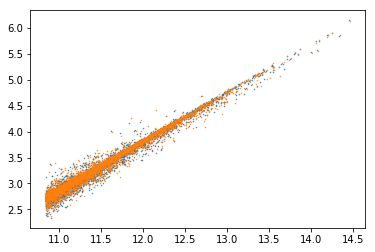

In [6]:
plt.scatter(np.log10(gr_data['Mvir']), np.log10(gr_data['Np']), s=0.2)
plt.scatter(np.log10(fr_data['Mvir']), np.log10(fr_data['Np']), s=0.2)

In [51]:
def find_LG_pairs(in_data):
    #pad boxes to mimic periodic boundary conditions
    new_data = in_data.copy()
    n = len(new_data)
    pos = np.ones([n,3])
    vel = np.ones([n,3])
    for i,j in zip([0,1,2], ['X','Y','Z']):
        pos[:,i] = new_data[j].copy()
        vel[:,i] = new_data['V'+j].copy()
    vmax = new_data['Vmax'].copy()
    mvir = new_data['Mvir'].copy()
    haloid = np.arange(n)

    pad_pos = pos.copy()
    pad_vel = vel.copy()
    pad_vmax = vmax.copy()
    pad_mvir = mvir.copy()
    pad_haloid = haloid.copy()

    for i in (0,1,-1):
        for j in (0,1,-1):
            for k in (0,1,-1):
                new_pos = pos.copy()
                if(i):
                    new_pos[:,0] = new_pos[:,0] + i*BoxSize
                if(j):
                    new_pos[:,1] = new_pos[:,1] + j*BoxSize
                if(k):
                    new_pos[:,2] = new_pos[:,2] + k*BoxSize
                
                if((i!=0) | (j!=0) | (k!=0)):
                    pad_pos = np.append(pad_pos, new_pos, axis=0)
                    pad_vel = np.append(pad_vel, vel, axis=0)
                    pad_vmax = np.append(pad_vmax, vmax)
                    pad_mvir = np.append(pad_mvir, mvir)
                    pad_haloid = np.append(pad_haloid, np.arange(n))

    

    #find neighbors
    nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(pad_pos)
    dist, ind = nbrs.kneighbors(pad_pos)
    print(pad_pos.shape)
    print(dist.shape)
    
    neighbor_index = ind[:,1]
    neighbor_list = ind[:,2:]
    print(np.shape(neighbor_list))

    #define pairs
    n_pairs = 0

    halo_A_id = np.empty((0), dtype=int)
    halo_B_id = np.empty((0), dtype=int)
    for i in range(n):
        j = neighbor_index[i] % n # nearest neighbor of i
        l = neighbor_index[neighbor_index[i]]% n # nearest neighbor of j
    
        other_j = neighbor_list[i,:] % n # all neightbors of i.
        other_l = neighbor_list[neighbor_index[i],:] % n # all neightbors of i-th's neighbors
        if(i==l):# reciprocity principle
            virial_radius_i = fr_data['Rvir'][i]
            virial_radius_l = fr_data['Rvir'][l]
            if(dist[i,1]<(virial_radius_i + virial_radius_l)): # Check that the halos are not merging
                if((not (j in halo_A_id)) & (not (j in halo_B_id))): # don't add pairs that are already in the list
                    vmax_i = pad_vmax[i]
                    vmax_j = pad_vmax[j]
                    vmax_limit = min([vmax_i, vmax_j])
                    dist_limit = max(3.0*hubble, 4.0*dist[i,1])
                    #dist_limit = 3.0*hubble
                    massive_close_to_i = any((dist[i,2:]<dist_limit) & (pad_vmax[other_j]>=vmax_limit))
                    massive_close_to_j = any((dist[j,2:]<dist_limit) & (pad_vmax[other_l]>=vmax_limit))
                    if((not massive_close_to_i) & (not massive_close_to_j)): 
                        n_pairs = n_pairs + 1
                        halo_A_id = np.append(halo_A_id, int(i))
                        halo_B_id = np.append(halo_B_id, int(j))
    return halo_A_id, halo_B_id, \
    pad_vmax[halo_A_id], pad_vmax[neighbor_index[halo_A_id]],\
    pad_mvir[halo_A_id], pad_mvir[neighbor_index[halo_A_id]],\
    pad_pos[halo_A_id,:], pad_pos[neighbor_index[halo_A_id], :],\
        pad_vel[halo_A_id,:], pad_vel[neighbor_index[halo_A_id], :]

In [52]:
halo_A_GR, halo_B_GR, vmax_A_GR, vmax_B_GR, mvir_A_GR, mvir_B_GR, pos_A_GR, pos_B_GR, vel_A_GR, vel_B_GR = find_LG_pairs(gr_data)
halo_A_FR, halo_B_FR, vmax_A_FR, vmax_B_FR, mvir_A_FR, mvir_B_FR, pos_A_FR, pos_B_FR, vel_A_FR, vel_B_FR = find_LG_pairs(fr_data)

(278127, 3)
(278127, 20)
(278127, 18)
(284877, 3)
(284877, 20)
(284877, 18)


In [53]:
# Number of pairs
print('FR', len(halo_A_FR))
print('GR', len(halo_A_GR))

FR 157
GR 142


In [54]:
relative_pos_GR = pos_B_GR - pos_A_GR
relative_vel_GR = vel_B_GR - vel_A_GR
norm_relative_vel_GR = np.sqrt((relative_vel_GR**2).sum(1))
norm_relative_pos_GR = np.sqrt((relative_pos_GR**2).sum(1))

#radial velocity includes Hubble flow
radial_vel_GR = ((relative_vel_GR[:,0] + relative_pos_GR[:,1]*100.0)*relative_pos_GR[:,0] +
            (relative_vel_GR[:,1] + relative_pos_GR[:,1]*100.0) *relative_pos_GR[:,1] + 
            (relative_vel_GR[:,2]+ relative_pos_GR[:,2]*100.0)*relative_pos_GR[:,2])/norm_relative_pos_GR

tangential_vel_GR = np.sqrt((relative_vel_GR[:,0] - relative_vel_GR[:,0]*relative_pos_GR[:,0])**2 +
                            (relative_vel_GR[:,1] - relative_vel_GR[:,1]*relative_pos_GR[:,1])**2 +
                            (relative_vel_GR[:,2] - relative_vel_GR[:,2]*relative_pos_GR[:,2])**2)

relative_pos_FR = pos_A_FR - pos_B_FR
relative_vel_FR = vel_A_FR - vel_B_FR
norm_relative_vel_FR = np.sqrt((relative_vel_FR**2).sum(1))
norm_relative_pos_FR = np.sqrt((relative_pos_FR**2).sum(1))

radial_vel_FR = ((relative_vel_FR[:,0] + relative_pos_FR[:,1]*100.0)*relative_pos_FR[:,0] +
            (relative_vel_FR[:,1] + relative_pos_FR[:,1]*100.0) *relative_pos_FR[:,1] + 
            (relative_vel_FR[:,2]+ relative_pos_FR[:,2]*100.0)*relative_pos_FR[:,2])/norm_relative_pos_FR

tangential_vel_FR = np.sqrt((relative_vel_FR[:,0] - relative_vel_FR[:,0]*relative_pos_FR[:,0])**2 +
                            (relative_vel_FR[:,1] - relative_vel_FR[:,1]*relative_pos_FR[:,1])**2 +
                            (relative_vel_FR[:,2] - relative_vel_FR[:,2]*relative_pos_FR[:,2])**2)

-50.1473608213 -37.0207210439


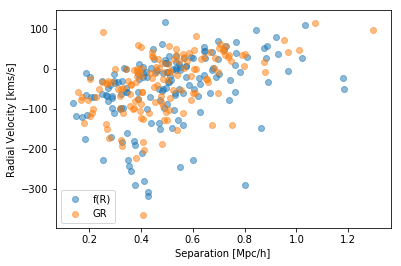

In [55]:
plt.scatter(norm_relative_pos_FR, radial_vel_FR, alpha=0.5, label="f(R)")
plt.scatter(norm_relative_pos_GR, radial_vel_GR, alpha=0.5, label="GR")
plt.xlabel("Separation [Mpc/h]")
plt.ylabel("Radial Velocity [kms/s]")
plt.legend()
print(radial_vel_FR.mean(), radial_vel_GR.mean())

mean negative radial velocity FR -84.2052805942
mean negative radial velocity GR -76.3448370121


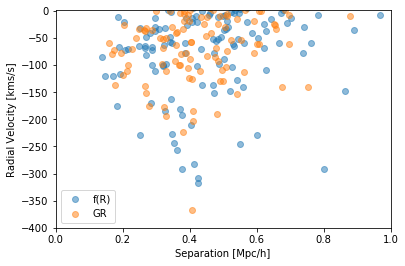

In [56]:
plt.scatter(norm_relative_pos_FR, radial_vel_FR, alpha=0.5, label="f(R)")
plt.scatter(norm_relative_pos_GR, radial_vel_GR, alpha=0.5, label="GR")
plt.xlim([0,1.0])
plt.ylim([-400.0,1.0])
plt.xlabel("Separation [Mpc/h]")
plt.ylabel("Radial Velocity [kms/s]")
plt.legend()
print("mean negative radial velocity FR",radial_vel_FR[radial_vel_FR<0].mean())
print("mean negative radial velocity GR", radial_vel_GR[radial_vel_GR<0].mean())

-50.1473608213 -37.0207210439


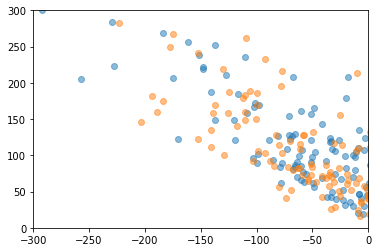

In [57]:
plt.scatter(radial_vel_FR, tangential_vel_FR, alpha=0.5)
plt.scatter(radial_vel_GR, tangential_vel_GR, alpha=0.5)
plt.xlim([-300.0,0.0])
plt.ylim([0,300])
print(radial_vel_FR.mean(), radial_vel_GR.mean())

Ks_2sampResult(statistic=0.11245178074818329, pvalue=0.28537834168246051)

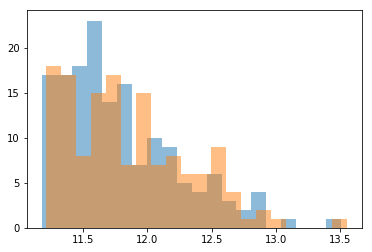

In [58]:
a = plt.hist(np.log10(mvir_A_FR + mvir_B_FR), bins=20, alpha=0.5)
a = plt.hist(np.log10(mvir_A_GR + mvir_B_GR), bins=20, alpha=0.5)
scipy.stats.ks_2samp(np.log10(mvir_A_FR + mvir_B_FR), np.log10(mvir_A_GR + mvir_B_GR))

Ks_2sampResult(statistic=0.080290661164438837, pvalue=0.70463105962803618)

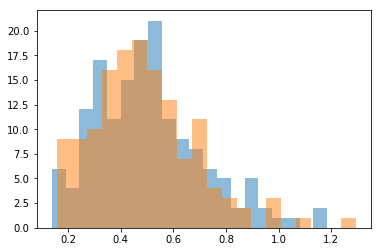

In [59]:
a = plt.hist(norm_relative_pos_FR, bins=20, alpha=0.5)
a = plt.hist(norm_relative_pos_GR, bins=20, alpha=0.5)
scipy.stats.ks_2samp(norm_relative_pos_FR,norm_relative_pos_GR)

Ks_2sampResult(statistic=0.084686462725396927, pvalue=0.63980008303294833)

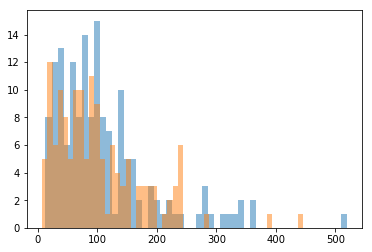

In [60]:
a = plt.hist(norm_relative_vel_FR, bins=50, alpha=0.5)
a = plt.hist(norm_relative_vel_GR, bins=50, alpha=0.5)
scipy.stats.ks_2samp(norm_relative_vel_FR,norm_relative_vel_GR)

Ks_2sampResult(statistic=0.084237911545707367, pvalue=0.64643226346637217)

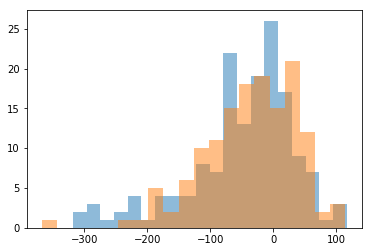

In [61]:
a = plt.hist(radial_vel_FR, bins=20, alpha=0.5)
a = plt.hist(radial_vel_GR, bins=20, alpha=0.5)
scipy.stats.ks_2samp(radial_vel_FR,radial_vel_GR)

Ks_2sampResult(statistic=0.12756795550372291, pvalue=0.16375817449185745)

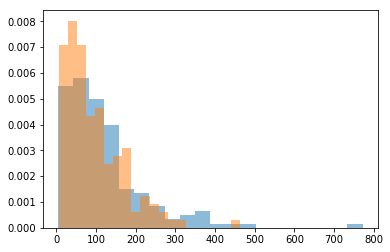

In [62]:
a = plt.hist(tangential_vel_FR, bins=20, alpha=0.5, normed=True)
a = plt.hist(tangential_vel_GR, bins=20, alpha=0.5, normed=True)
scipy.stats.ks_2samp(tangential_vel_FR,tangential_vel_GR)

In [73]:
ii_FR = (radial_vel_FR<-90.0)&(radial_vel_FR>-135)
ii_GR = (radial_vel_GR<-90.0)&(radial_vel_GR>-135)
print(np.count_nonzero(ii_FR), np.count_nonzero(ii_GR))

13 18


median separation FR 0.321481825769
median separation GR 0.397492866397


Ks_2sampResult(statistic=0.33760683760683763, pvalue=0.29026856649222538)

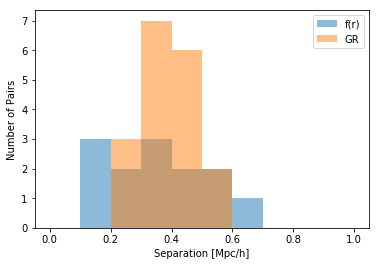

In [74]:
a = plt.hist(norm_relative_pos_FR[ii_FR], bins=np.linspace(0.0,1.0,11), alpha=0.5, label='f(r)')
a = plt.hist(norm_relative_pos_GR[ii_GR], bins=np.linspace(0.0,1.0,11), alpha=0.5, label='GR')
plt.xlabel('Separation [Mpc/h]')
plt.ylabel('Number of Pairs')
plt.legend()

print('median separation FR', np.percentile(norm_relative_pos_FR[ii_FR],q=50))
print('median separation GR', np.percentile(norm_relative_pos_GR[ii_GR],q=50))
scipy.stats.ks_2samp(norm_relative_pos_FR[ii_FR],norm_relative_pos_GR[ii_GR])

median log10 total mass FR 11.9361114317
median log10 total mass GR 12.2089602816


Ks_2sampResult(statistic=0.35042735042735046, pvalue=0.25033212029279933)

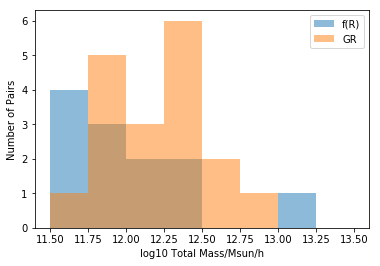

In [77]:
a = plt.hist(np.log10(mvir_A_FR[ii_FR]+mvir_B_FR[ii_FR]), bins=np.linspace(11.5,13.5,9), alpha=0.5, label='f(R)')
a = plt.hist(np.log10(mvir_A_GR[ii_GR]+mvir_B_GR[ii_GR]), bins=np.linspace(11.5,13.5,9), alpha=0.5, label='GR')
plt.xlabel('log10 Total Mass/Msun/h')
plt.ylabel('Number of Pairs')
plt.legend()
print('median log10 total mass FR', np.percentile(np.log10(mvir_A_FR[ii_FR]+mvir_B_FR[ii_FR]),q=50))
print('median log10 total mass GR', np.percentile(np.log10(mvir_A_GR[ii_GR]+mvir_B_GR[ii_GR]),q=50))
scipy.stats.ks_2samp(np.log10(mvir_A_FR[ii_FR]+mvir_B_FR[ii_FR]), np.log10(mvir_A_GR[ii_GR]+mvir_B_GR[ii_GR]))

median vtan FR 166.122090198
median vtan GR 164.565661505


Ks_2sampResult(statistic=0.13675213675213671, pvalue=0.99742690709052406)

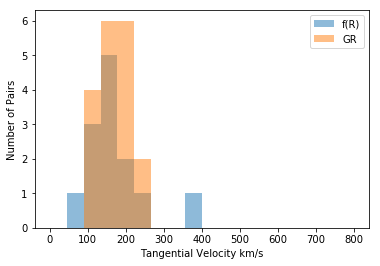

In [78]:
a = plt.hist(tangential_vel_FR[ii_FR], bins=np.linspace(0,800,19), alpha=0.5, label='f(R)')
a = plt.hist(tangential_vel_GR[ii_GR], bins=np.linspace(0,800,19), alpha=0.5, label='GR')
plt.xlabel('Tangential Velocity km/s')
plt.ylabel('Number of Pairs')
plt.legend()
print('median vtan FR', np.percentile(tangential_vel_FR[ii_FR], q=50))
print('median vtan GR', np.percentile(tangential_vel_GR[ii_GR], q=50))
scipy.stats.ks_2samp(tangential_vel_FR[ii_FR],tangential_vel_GR[ii_GR])